<a href="https://colab.research.google.com/github/Sciform/sciform-hwz-ai-in-controlling/blob/main/ts_03_moving_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple time series forecasting with moving average

Moving average is a classical appraoch to time series forecasting, where the predicted value is the mean of window of previous values.

## Setup

In [ ]:
!pip install tensorflow==2.16.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Print Keras version
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.3.3


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

## Create an additive time series

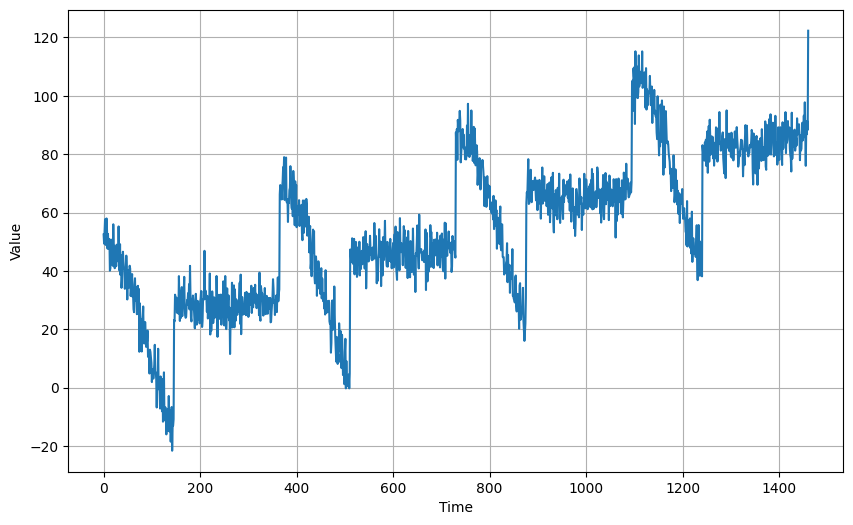

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Naive forecast

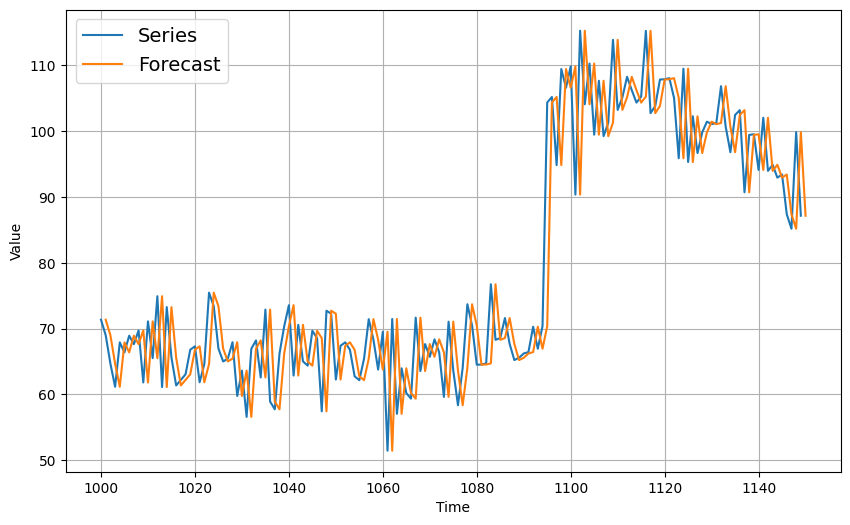

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

Now let's compute the mean absolute error between the forecasts and the predictions in the validation period:

In [5]:
print(f"The MAE is = {keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()}")

The MAE is = 5.9379085153216735


In [6]:
print(f"The MSE is = {keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()}")

The MSE is = 61.82753366856369


In [7]:
# root mean square error
print(f"The RMSE is = {np.sqrt(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())}")

The RMSE is = 7.863048624329096


In [16]:
mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
mape = mape_metric(x_valid, naive_forecast).numpy()
print(f"The MAPE is = {mape} %")


The MAPE is = 7.845698833465576 %


That's our baseline, now let's try a moving average.

## Moving average

Tomorrow will be close to the average over the values of the past few days.

1. We have to choose a window size (a specific number of time step)
2. Then we slide the window along the time series
3. In every sliding step we compute the mean of the values in the window and use it as forecast for the next time step

In [17]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     Adjust the windows size and see which window size performs best.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  # for every entry in the time series (except the first N=window_size entries)
  for time in range(len(series) - window_size):
    # compute the mean values of the time series values in the window and store as forecast for the next time step
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [18]:
def moving_average_forecast(series, window_size):
  """This implementation provides the same result as the above on but is *much* faster.
     Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     Adjust the windows size and see which window size performs best.
  """
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

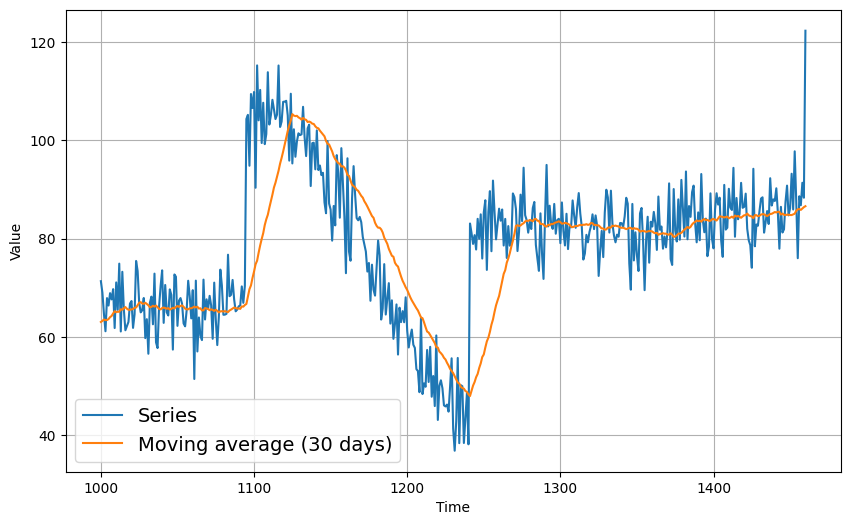

In [19]:
window_size = 30
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [20]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.142418570620786

### Differencing

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

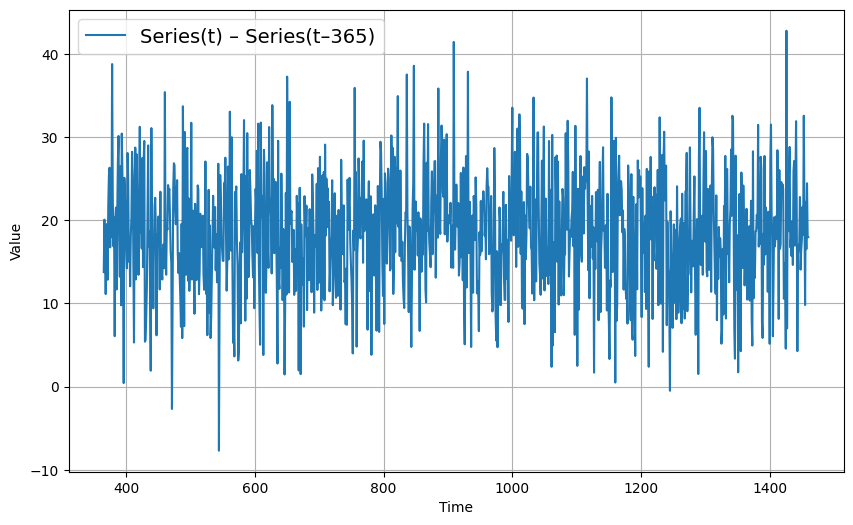

In [21]:
# Negative -365 is interpreted as t-365 t is the number of elements in the corresponding dimension
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

Focusing on the validation period:

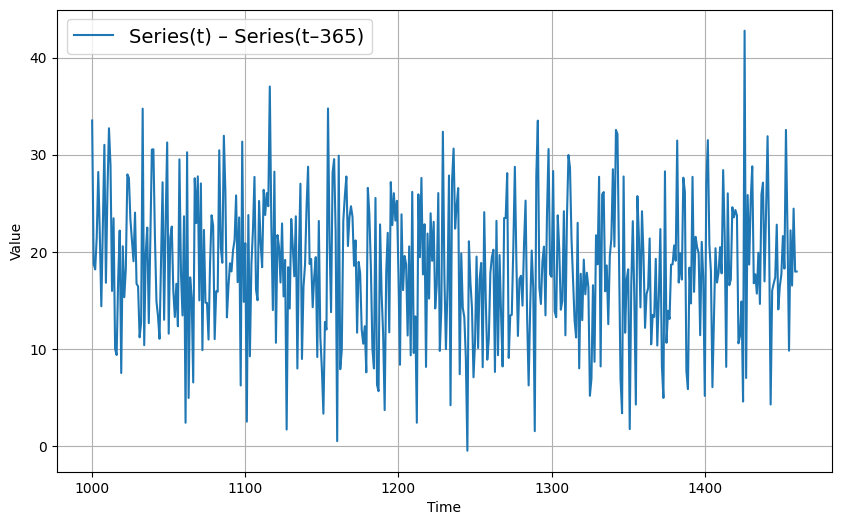

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

## Moving average forecast on time series with differencing

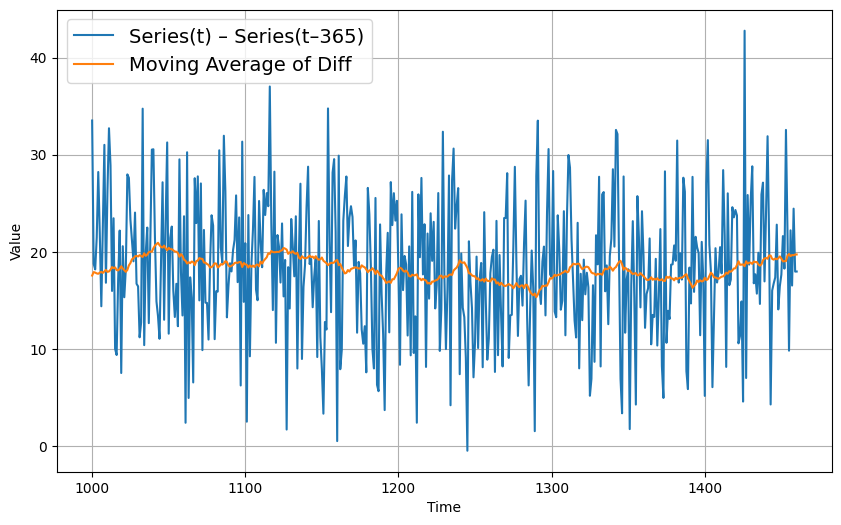

In [23]:
window_size = 48
diff_moving_avg = moving_average_forecast(diff_series, window_size)[split_time - 365 - window_size:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

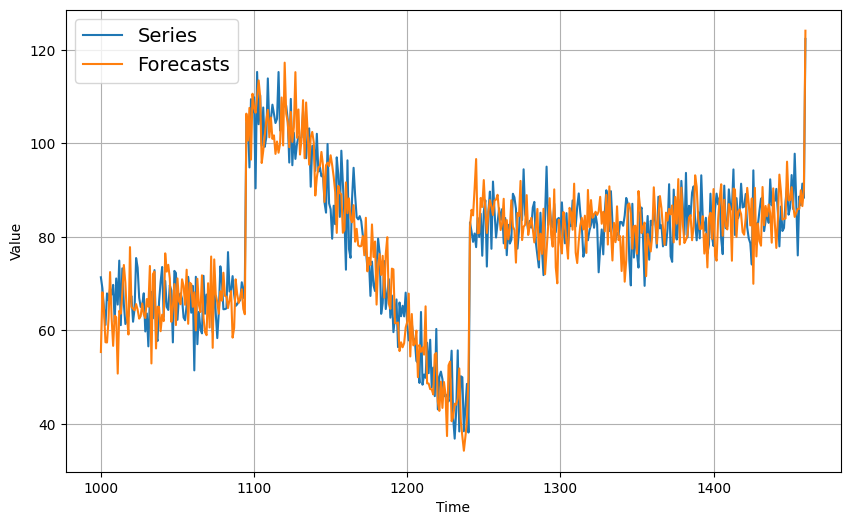

In [24]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [25]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.838745766196426

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

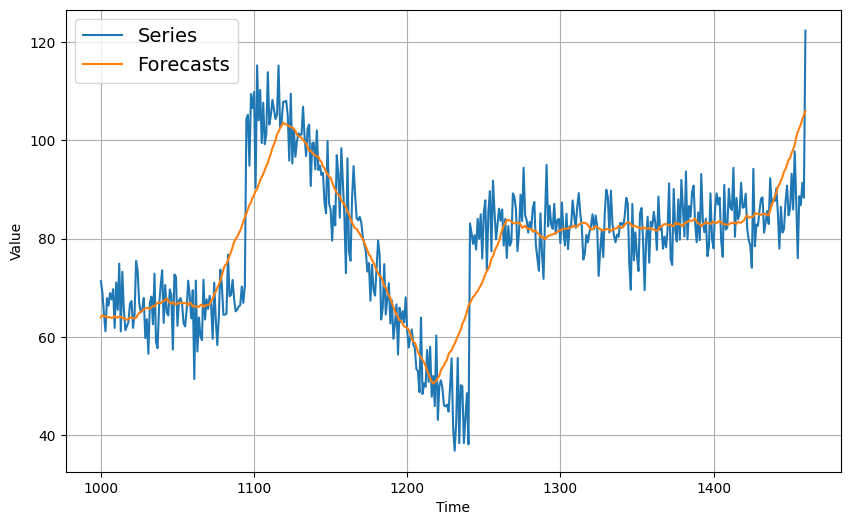

In [26]:
# find a better window size than 48

window_size_2 = 48
half_window_size_2 = int(window_size_2/2)
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time-(365+half_window_size_2):-(365-half_window_size_2)], window_size_2) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [27]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

5.638994030171174

That's starting to look pretty good! Let's see if we can do better with a Machine Learning model.

In [20]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Source: https://github.com/tensorflow/examples